In [ ]:
cd ../TileEM/

In [10]:
%pylab inline
%load_ext autoreload
%autoreload 2
from paper_visualizations import * 
from PixelEM import * 
from test_sample import test_sample_obj
import json
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Algorithm : 
   - Given object j and a set of tiles {t_i}, 
   
1. compute the overlap area with GT and sort tiles according to that order 
2. greedily pick the tile with the largest overlap area and compute Jaccard at every step
3. stop when Jaccard decreases.

In [8]:
ls final_run/10worker_rand0/tiles10.pkl

final_run/10worker_rand0/tiles10.pkl


In [11]:
df = pd.read_csv("all_info.csv",index_col=0)
df_object_batch = pd.read_csv("all_object_batch_info.csv",index_col=0)
df_worker = pd.read_csv("all_worker_response_info.csv",index_col=0)
df_object = pd.read_csv("all_object_info.csv",index_col=0)
df_tile = pd.read_csv("all_tile_info.csv",index_col=0)
df_worker_tile = pd.read_csv("all_worker_tile_info.csv",index_col=0)

In [213]:
df_tile["overlap frac"]= df_tile["gt overlap area"]/df_tile["tile area"]
df_tile["outside area"]= df_tile["tile area"]-df_tile["gt overlap area"]

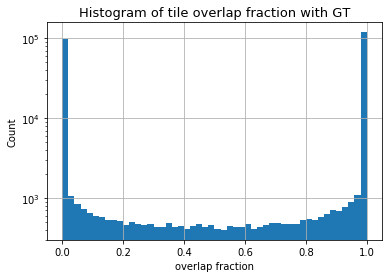

In [215]:
plt.title("Histogram of tile overlap fraction with GT",fontsize=13)
df_tile["overlap frac"].hist(bins=50,log=True)
plt.xlabel("overlap fraction")
plt.ylabel("Count")

In [221]:
import shapely
from qualityBaseline import *

In [270]:
sorted_df_tile_subset = df_tile_subset.sort("overlap frac",ascending=False)
tile_lst = list(sorted_df_tile_subset["tile id"])

In [219]:
sorted_df_tile_subset = df_tile_subset.sort(["overlap frac",'tile area'],ascending=False)
tile_lst = list(sorted_df_tile_subset["tile id"])

In [223]:
def jaccard(poly1,poly2):
    ia = poly1.intersection(poly2).area
    ua= poly1.area+poly2.area-ia
    return ia/float(ua)

In [303]:
def run_tile_upper_bound(batch,objid,heuristic_sorty_by='overlap frac'):
    df_tile_subset = df_tile[(df_tile["batch"]==batch)&(df_tile["objid"]==objid)]

    sorted_df_tile_subset = df_tile_subset.sort(heuristic_sorty_by,ascending=False)
    tile_lst = list(sorted_df_tile_subset["tile id"])

    tiles = pkl.load(open("uniqueTiles/{}/vtiles{}.pkl".format(batch,objid)))

    GT  = ground_truth_T(objid)

    Tprime = [tile_lst[0]]
    #Tprime = [tiles[0]]
    selected_tiles_Tprime = df_tile_subset[df_tile_subset["tile id"].isin(Tprime)]
    jlst = [selected_tiles_Tprime["gt overlap area"].sum()/(selected_tiles_Tprime["outside area"].sum()+GT.area)]
    jprev = 0
    jcurr = 0
    i=0
    while(jprev<=jcurr):
        tidx=tile_lst[i]
        selected_tiles_Tprime = df_tile_subset[df_tile_subset["tile id"].isin(Tprime)]
        jprev=jcurr
        #Tprime = Tprime.union(tiles[tidx])
        #jcurr = jaccard(Tprime,GT)
        Tprime.append(tidx)
        #jcurr = jaccard(tiles[tidx],GT)
        jcurr = selected_tiles_Tprime["gt overlap area"].sum()/(selected_tiles_Tprime["outside area"].sum()+GT.area)
        jlst.append(jcurr)
        #print jprev,jcurr
        i+=1
    return jlst 

This is what happens if you sort by tile area and greedily pick the largest tile at every step . 

In [288]:
def plot_jlst(jlst,heuristic):
    plt.plot(jlst)
    plt.title("{};obj{} [{} heuristic]".format(batch,objid,heuristic))
    plt.xlabel("Iterations",fontsize=13)
    plt.ylabel("Jaccard",fontsize=13)

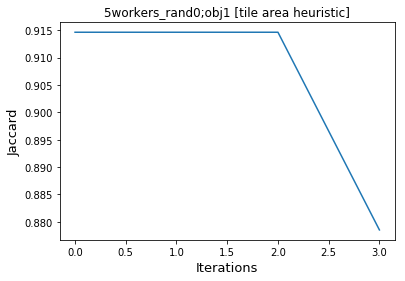

In [289]:
jlst = run_tile_upper_bound(batch,objid,heuristic_sorty_by='tile area')
plot_jlst(jlst,'tile area')

## sort only by tile fraction

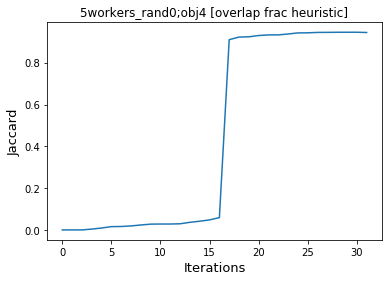

In [304]:
jlst = run_tile_upper_bound(batch,objid,heuristic_sorty_by='overlap frac')
plot_jlst(jlst,'overlap frac')

0.942887415781


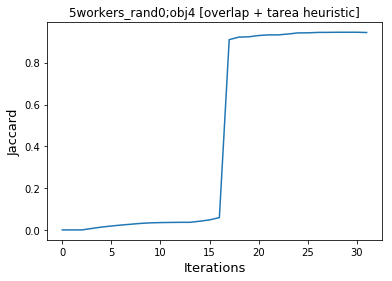

In [305]:
jlst = run_tile_upper_bound(batch,objid,heuristic_sorty_by=["overlap frac",'tile area'])
plot_jlst(jlst,'overlap + tarea')
print jlst[-1]

In [306]:
def plot_coords(obj, color='red', reverse_xy=False, linestyle='-', fill_color="", show=False, invert_y=False):
    #Plot shapely polygon coord
    if type(obj) != shapely.geometry.MultiPolygon:
        obj = [obj]

    for ob in obj:
        if ob.exterior is None:
            print 'Plotting bug: exterior is None (potentially a 0 area tile). Ignoring and continuing...'
            continue
        if reverse_xy:
            x, y = ob.exterior.xy
        else:
            y, x = ob.exterior.xy
        plt.plot(x, y, linestyle, linewidth=0, color=color, zorder=1)
        if fill_color != "":
            plt.fill_between(x, y, facecolor=fill_color,  linewidth=0, alpha=0.5)
    if invert_y:
        plt.gca().invert_yaxis()

In [298]:
def visualizeTilesSeparate(tiles,colorful=True):
#     plt.figure()
    colors=cm.rainbow(np.linspace(0,1,len(tiles)))
    for t,i in zip(tiles,range(len(tiles))):
#         plt.figure()
        if colorful:
            c = colors[i]
        else:
            #c="lime"
            c="blue"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True,fill_color=c)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True,fill_color=c)
    #xylocs of the largest tile for estimating the obj size
    xlocs,ylocs = tiles[np.argmax([t.area for t in tiles])].exterior.coords.xy
    plt.ylim(np.min(ylocs)-50,np.max(ylocs)+50)
    plt.gca().invert_yaxis()

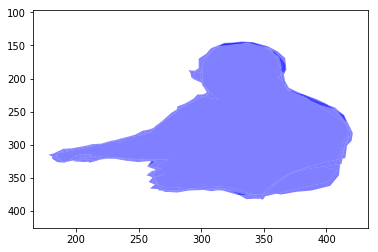

In [299]:
visualizeTilesSeparate(tiles,colorful=False)

In [318]:
best_jtbl = []
object_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47]
tile_tbl =[]
for batch in ['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0']:
    for objid in object_lst:
        jlst = run_tile_upper_bound(batch,objid,heuristic_sorty_by='overlap frac')
        best_jtbl.append([batch,objid,jlst[-1]])

In [404]:
bjtbl = pd.DataFrame(best_jtbl,columns=["batch","objid","tile upper bound jaccard"])

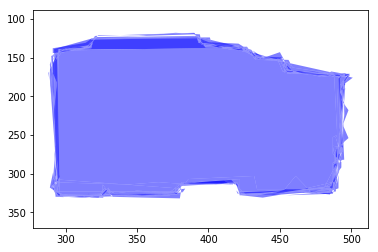

In [327]:
batch='25workers_rand0'
objid = 38
tiles = pkl.load(open("uniqueTiles/{}/vtiles{}.pkl".format(batch,objid)))
visualizeTilesSeparate(tiles,colorful=False)

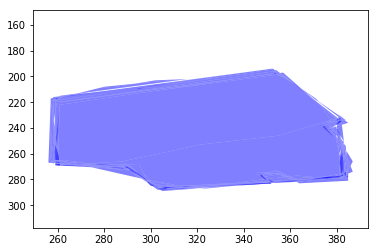

In [328]:
batch='25workers_rand0'
objid = 9
tiles = pkl.load(open("uniqueTiles/{}/vtiles{}.pkl".format(batch,objid)))
visualizeTilesSeparate(tiles,colorful=False)

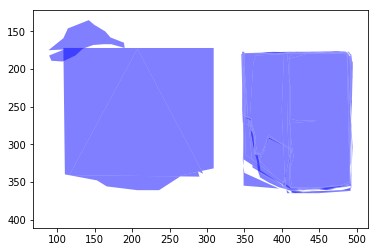

In [329]:
batch='20workers_rand0'
objid = 20
tiles = pkl.load(open("uniqueTiles/{}/vtiles{}.pkl".format(batch,objid)))
visualizeTilesSeparate(tiles,colorful=False)

### Compare best jaccard tile with majority vote and best individual workers 

In [333]:
ls ../*.csv

../computed_my_COCO_BBvals.csv  ../my_ground_truth.csv


In [411]:
df = pd.read_csv("../computed_my_COCO_BBvals.csv",index_col=0)
# df_best_worker = df.groupby('object_id',as_index=False).apply(max)[["Jaccard [Self]"]]
# df_best_worker = df_best_worker.reset_index().rename(columns={'index':'objid','Jaccard [Self]':'Best Worker Jaccard'})

In [428]:
# df_best_worker   = df_worker.groupby('objid',as_index=False).apply(max)[["J [GT]"]].reset_index().rename(columns={'index':'objid','J [GT]':'Best Worker Jaccard'})

In [464]:
MV = pd.read_csv("pixel_em/MV_PRJ_table.csv")

In [471]:
pd.Series.str(MV["num_workers"])

In [476]:
MV["workers_rand"]="workers_rand"

In [479]:
MV["batch"]=MV["num_workers"].astype(str)+MV["workers_rand"]+ MV["sample_num"].astype(str)

In [502]:
MV_cleaned=MV[["batch","objid","MV_jaccard"]].rename(columns={'MV_jaccard':'Pixel MV Jaccard'})

In [527]:
batch = sample_specs.keys()[0]
df = pd.read_csv("uniqueTiles/{}/Tile_PR.csv".format(batch),index_col=0)
df["batch"]=batch
df_all = df[["batch","object_id","J [MVT]"]]
for batch in sample_specs.keys()[1:]: 
    df = pd.read_csv("uniqueTiles/{}/Tile_PR.csv".format(batch),index_col=0)
    df["batch"]=batch
    df = df[["batch","object_id","J [MVT]"]]
    df_all=pd.concat([df_all,df])

df_tilemv = df_all.rename(columns={'object_id':'objid','J [MVT]':'Tile MV Jaccard'})

In [531]:
df_worker_batch = df_worker_tile[['batch','objid','worker id']].drop_duplicates()
df_best_worker =df_worker_batch.merge(df_worker).groupby(['batch','objid'],as_index=False).apply(max)[["J [GT]"]].reset_index().rename(columns={'J [GT]':'Best Worker Jaccard'})
comparison_tbl = bjtbl.merge(df_best_worker).merge(MV_cleaned).merge(df_tilemv)

In [549]:
comparison_tbl[['tile upper bound jaccard', u'Best Worker Jaccard','Pixel MV Jaccard', u'Tile MV Jaccard']].mean()

tile upper bound jaccard    0.948708
Best Worker Jaccard         0.912912
Pixel MV Jaccard            0.882326
Tile MV Jaccard             0.859552
dtype: float64

In [550]:
comparison_tbl[['tile upper bound jaccard', u'Best Worker Jaccard','Pixel MV Jaccard', u'Tile MV Jaccard']].rank(axis=1).sum()

tile upper bound jaccard    1021
Best Worker Jaccard          693
Pixel MV Jaccard             486
Tile MV Jaccard              432
dtype: float64

larger ranks means higher values 

In [547]:
# comparison_tbl[['tile upper bound jaccard', u'Best Worker Jaccard','Pixel MV Jaccard', u'Tile MV Jaccard']].ix[0]
# comparison_tbl[['tile upper bound jaccard', u'Best Worker Jaccard','Pixel MV Jaccard', u'Tile MV Jaccard']].ix[0].rank()